[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/Rabinovich_Fabrikant_System_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb)

# Rabinovich-Fabrikant system Time Series Analysis using EMD and Dilated Convolutional Neural Networks


---


https://www.comp-engine.org/#!visualize/8932bda7-3872-11e8-8680-0242ac120002

[The Rabinovich-Fabrikant system](https://en.wikipedia.org/wiki/Rabinovich%E2%80%93Fabrikant_equations) is a system of differential equations that, given certain parameter values, exhibits chaotic behavior. I took this time series from comp-engine.org, don't know the exact parameter values. However, in summary, 

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/22e5a9c1b603c274182eccd797c6edd1ca3c530b)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/1a1735609c119fa27df62b7ff5b17d194ceffab4)
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/8bdd713faa00121d85adb8cf04bdcab3a071a0b2)


In [0]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [0]:
from google.colab import files    
files.upload()




In [0]:
import numpy as np  
data = np.fromfile("lorenz.dat", sep = "\n")

data.shape

In [9]:
import numpy as np
data = np.genfromtxt("rabfab.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

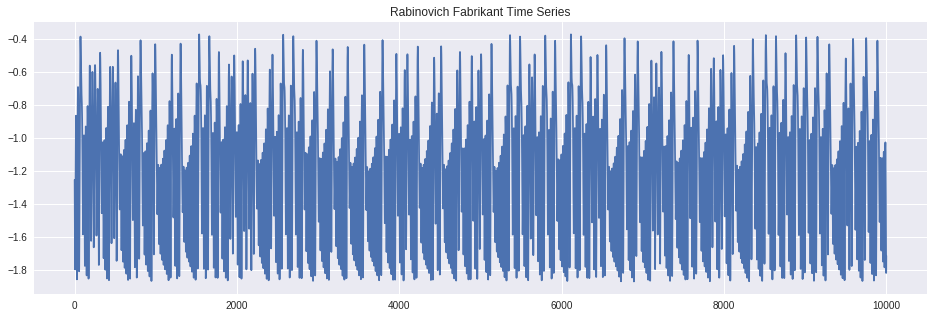

In [10]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("Rabinovich Fabrikant Time Series")
plt.show()

In [11]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [43]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-4000]; out_sample = scaled_data[-4000:]
print(in_sample.shape)

(6000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

#Empirical Mode Decomposition


In [0]:
!pip install EMD-signal
from PyEMD import EEMD 

In [0]:
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)

In [46]:
imfs1 = eemd(in_sample, t)

print(imfs1.shape)

(15, 6000)


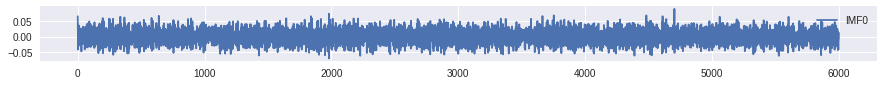

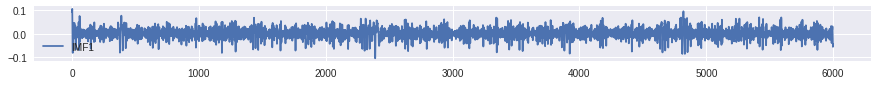

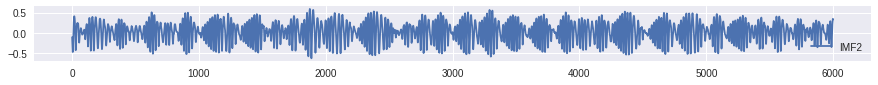

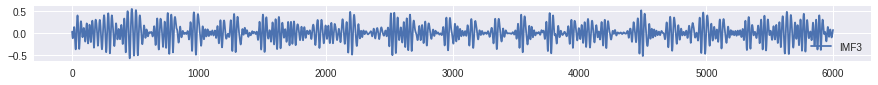

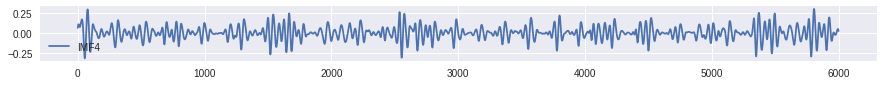

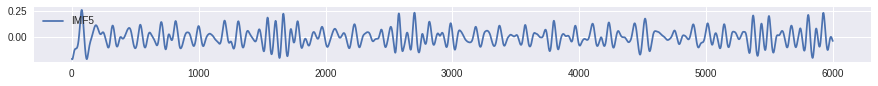

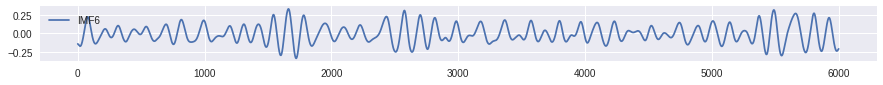

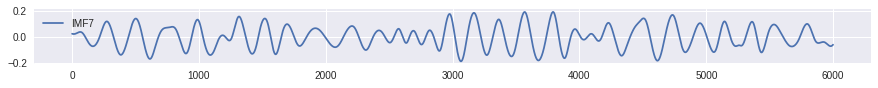

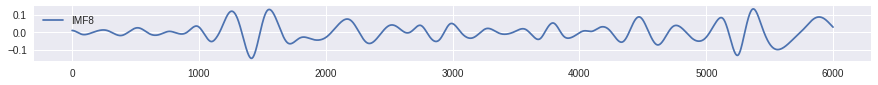

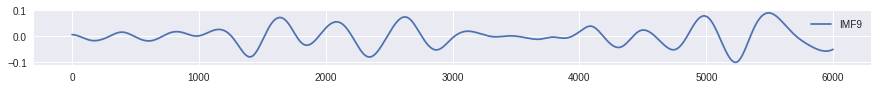

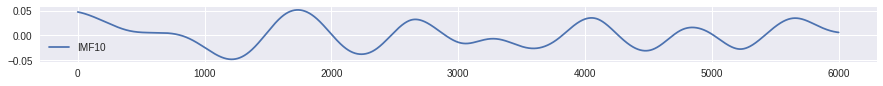

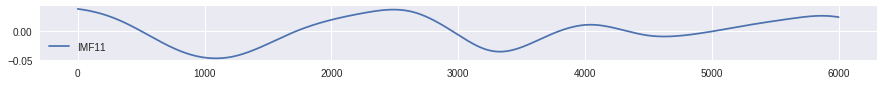

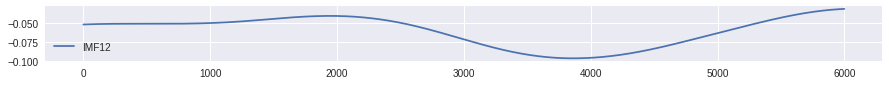

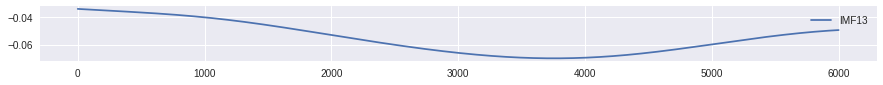

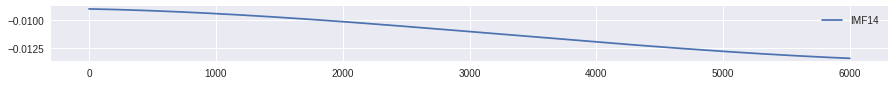

In [47]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(15,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

# Creating Datasets


In [48]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(6000, 1)


In [0]:
lookback = 10
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [53]:
# this is the raw data, broken into sequences of 20 that result in sequence of 1.
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
print(Xr.shape)

(5990, 11)
(5990, 10)


# All IMFs

In [56]:
imfs1.shape

(15, 6000)

In [59]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); 
print(imfs1.shape)
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)
imf_df = np.reshape(imf_df, (5990, 11, 15))

print(imf_df.shape)

(6000, 15)
(5990, 1, 165)
(5990, 11, 15)


In [60]:
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(5990, 15)


In [63]:
#so reshape everything properly
input_data = np.reshape(Xr, (5990, 1, 10))
targets = np.reshape(targets,(5990, 1, 15))
print(input_data.shape, targets.shape)

(5990, 1, 10) (5990, 1, 15)


In [0]:
#great everything is good 

In [65]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testX = out_df[:,:-1]; testX = np.expand_dims(testX, axis = 1); print(testX.shape)
testY = out_df[:,-1]; print(testY.shape)

(3990, 11)
(3990, 1, 10)
(3990,)


# Partial autocorrelation 

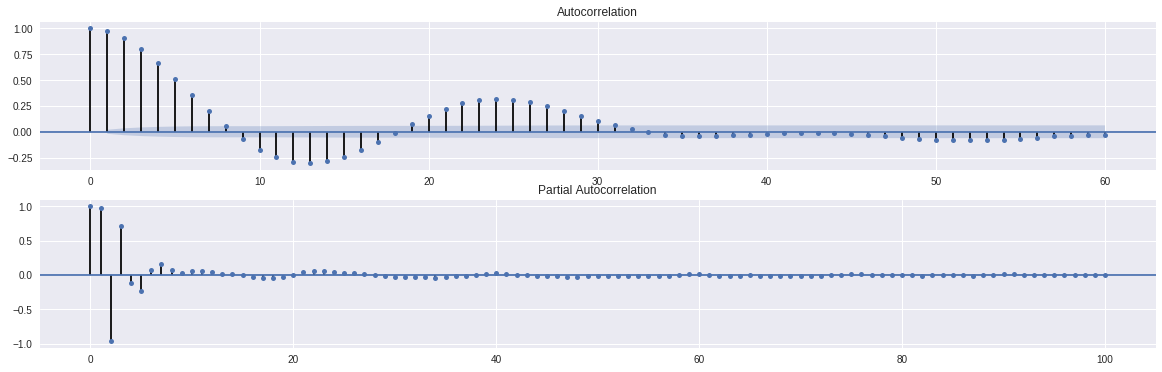

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [68]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import LeakyReLU
from keras import optimizers
np.random.seed(2018) #inputs are (1, 20) and outputs are #(1 time step,17 features)
pad = "causal"
inputs = Input(shape = (1, lookback))


x0 = Conv1D(32, 3, padding = pad, dilation_rate = 2, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
x1 = Conv1D(32, 3, padding = pad, dilation_rate = 4, activation = "tanh",  kernel_initializer = "glorot_uniform")(inputs)
x2 = Conv1D(32, 3, padding = pad, dilation_rate = 8, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)


x = concatenate([inputs, x0, x1, x2])
#x = Dropout(0.25)(x)

#x = Conv1D(256, 3, padding = pad, dilation_rate = 8, kernel_initializer = "he_normal", activation = "tanh")(x)
x = Conv1D(64, 3, padding = pad, dilation_rate = 2, kernel_initializer = "he_normal", activation = "tanh")(x)

predictions = Conv1D(15, 3, padding = pad, dilation_rate = 1, activation = "tanh")(x)


model = Model(inputs = inputs, outputs = predictions)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 30, verbose = 1)

model.compile(optimizer = optimizers.Adadelta(lr = 1, clipnorm = 1.), loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1, 10)        0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 1, 32)        992         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 1, 32)        992         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 1, 32)        992         input_4[0][0]                    
__________________________________________________________________________________________________
concatenat

In [69]:
predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)

(3990, 1, 15)


(3990, 1)
(3990,)


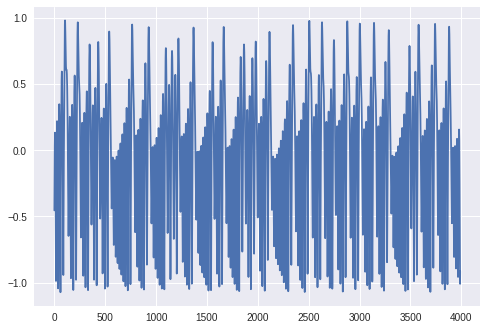

In [70]:
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape

Final R2 Score is: 0.9934436674390722


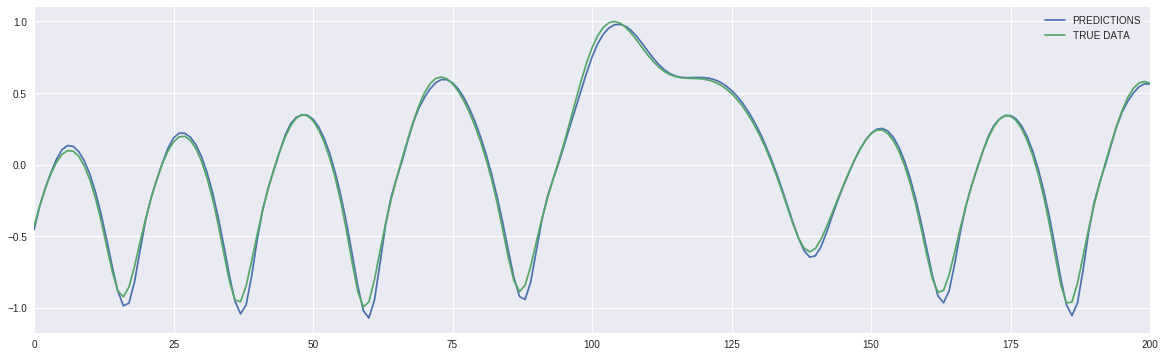

In [71]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,200])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()